# Convolutional Neural Net for Binary Classification using Spectrograms

### Some Setup

We want to be able to run the notebook both locally and in Google Colab

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
  !pip install torchmetrics
  !pip install kornia
  !pip install torchvision
  google.colab.drive.mount('/content/drive')
  %cd /content/drive/My Drive/Go-Viral-Project/notebooks



In Colab: False


Imports

In [ ]:
import sys; sys.path.append('..')
import os
import torch
from torch.utils.data import random_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torchvision import transforms
from src.RNN_utils.dataset import SoundDS
from torch.utils.data import default_collate
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate
from kornia.losses.focal import BinaryFocalLossWithLogits
from torchmetrics.classification import ConfusionMatrix

In [3]:
def plotTrainRes(resutls, num_epochs):
    fig, axs = plt.subplots(1,2, figsize=(15,5))

    axs[0].plot(range(num_epochs), resutls['loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(num_epochs), resutls['accuracy'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')

Setting paths

In [4]:
AUDIO_PATH = '../data/audio'
TENSOR_PATH = '../data/specs'
METADATA_PATH = '../data/audio_features.csv'

 Setting seed for reproducability

In [5]:
SEED = 42
torch.manual_seed(SEED)

Setting device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


### Cleaning up Dataset

Creating binary target using the threshold of $5e5$.

In [6]:
df = pd.read_csv(METADATA_PATH)
df["viral"] = (df["number_of_videos"] > 5e5).astype("int64")

Removing songs that dont have spectrograms (just in case)

In [7]:
data_path = '../data/specs/'
files_not_found = 0

for idx, row in df.iterrows():
    song_path = os.path.join(data_path, row['id'] + '.pt')

    if not os.path.exists(song_path):
        df = df.drop(idx)
        files_not_found += 1

print(f"Number of files not found: {files_not_found}")

Number of files not found: 289


### Preprocessing

MobileNet V2 requires some preprocessing to the input, size of at least 224 for the height and width and 3 channels (RGB). In addition, it requires normalization.

In [9]:
def preprocess_mbnet(X):
  prep = transforms.Compose([
      transforms.Resize((224,2206)),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  return prep(torch.cat((X,X,X),dim=0))

Now we can continue with the dataloaders:

In [10]:
myds = SoundDS(df, '../data/specs/', preprocess_mbnet)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

to_gpu = lambda x: list(map(lambda t: t.to(device), default_collate(x)))

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, collate_fn = to_gpu, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, collate_fn = to_gpu, shuffle=False)

In [11]:
b_size, channels, hight, width = next(iter(train_dl))[0].shape
num_batches = len(train_dl)
print(f'num batches: {num_batches}\nbatch size: {b_size}\nchannels: {channels}\nhight: {hight} \nwidth: {width}')

c:\GitHub\go-viral\go-viral\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


num batches: 183
batch size: 16
channels: 3
hight: 224 
width: 2206


## MobileNet V2:

### Overfitting the model:

Loading the model

In [18]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

EPOCHS = 10
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\tomer/.cache\torch\hub\pytorch_vision_v0.10.0


In [19]:
# sum(param.numel() for param in model.parameters())
print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of trainable parameters: 2226434


In [20]:
(X,y) = next(iter(train_dl))

Now let's overfit the model to this batch:

In [21]:
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    y_prob = model(X)
    loss = criterion(y_prob,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    scheduler.step()
    acc = torch.sum(torch.argmax(y_prob,dim=1)==y).item()/b_size
    print(f'Epoch #{epoch}: Loss - {loss}, Accuracy - {acc}')

Epoch #0: Loss - 0.7485800981521606, Accuracy - 0.1875
Epoch #1: Loss - 0.48839861154556274, Accuracy - 0.9375
Epoch #2: Loss - 0.3770751655101776, Accuracy - 1.0
Epoch #3: Loss - 0.33046308159828186, Accuracy - 1.0
Epoch #4: Loss - 0.31949108839035034, Accuracy - 1.0
Epoch #5: Loss - 0.316195011138916, Accuracy - 1.0
Epoch #6: Loss - 0.3147968053817749, Accuracy - 1.0
Epoch #7: Loss - 0.31415072083473206, Accuracy - 1.0
Epoch #8: Loss - 0.31383171677589417, Accuracy - 1.0
Epoch #9: Loss - 0.3136598765850067, Accuracy - 1.0


### Training the model:

Let's do a real full train to see if everything works properly:

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.2)

Using cache found in C:\Users\tomer/.cache\torch\hub\pytorch_vision_v0.10.0


In [23]:
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
results = train_model.train(train_dl,20,True)

In [ ]:
plotTrainRes(results,20)

## Cross Validation:

### Cross Validation with Cross-Entropy Loss

Initializing lists to hold results and configs

In [12]:
configs = []
results = []

Loading model

In [ ]:
# Uncomment one configuration and run this cell
#config = {'lr':1e-4, 'weight_decay':5e-5, 'step_size': 3, 'gamma': 0.2, 'dropout': 0.2}
#config = {'lr':1e-3, 'weight_decay':1e-4, 'step_size': 4, 'gamma': 0.1, 'dropout': 0.3}
#config = {'lr':1e-3, 'weight_decay':1e-4, 'step_size': 10, 'gamma': 0.1, 'dropout': 0.0}
#config = {'lr':1e-4, 'weight_decay':1e-4, 'step_size': 10, 'gamma': 0.1, 'dropout': 0.0}


model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout1d(p=config['dropout']),
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

Initializing CV object

In [14]:
cv_obj = crossValidate(train_ds=train_ds, device=device, folds=3, batch_size=16)

Running CV

In [ ]:
results.append(cv_obj.runCV(train_model, epochs=10))
configs.append(config)

After we finish to run all the configuration, let's plot them:

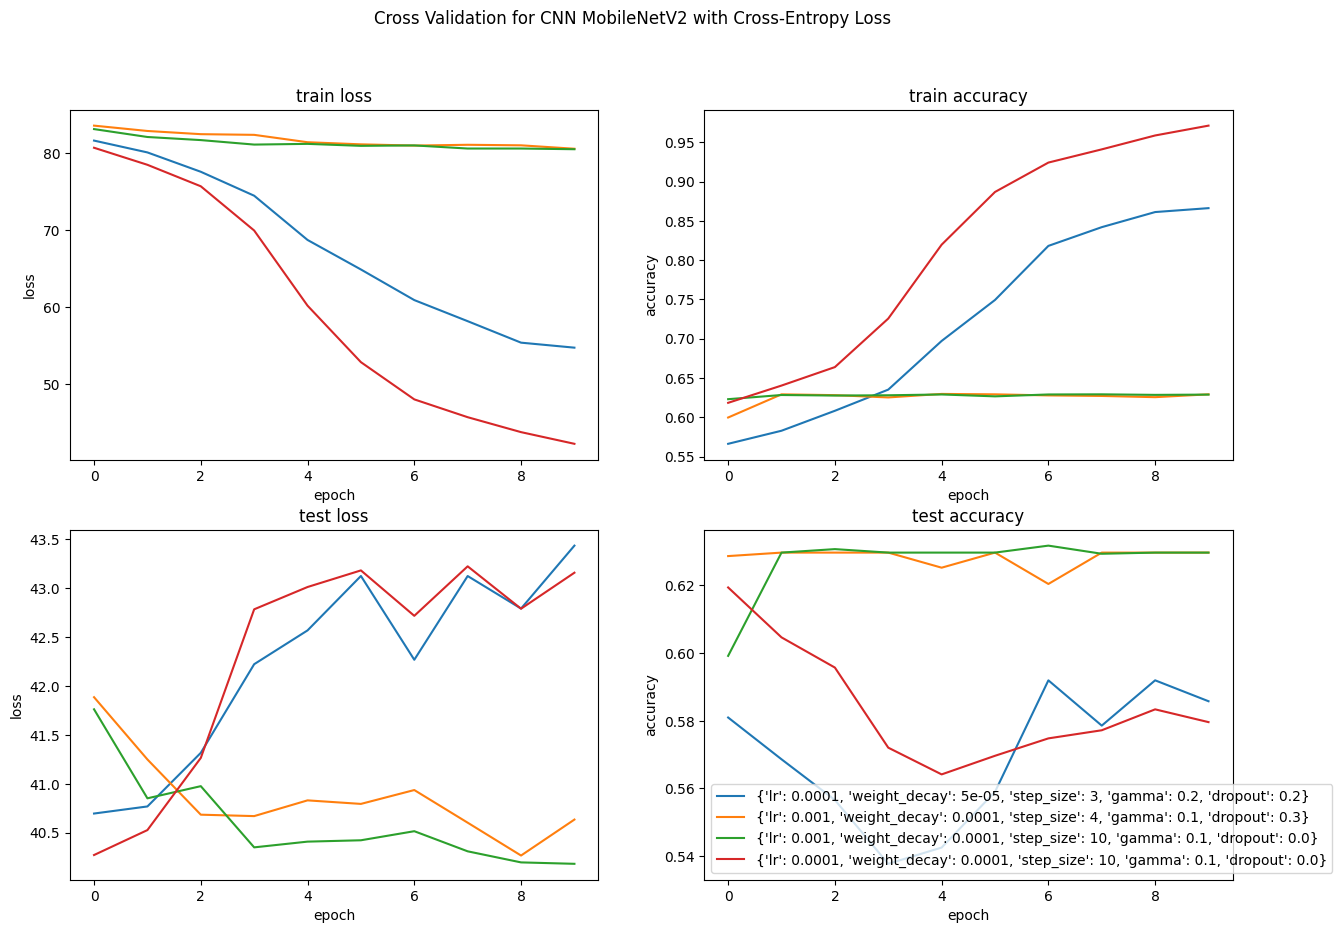

In [25]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='Cross Validation for CNN MobileNetV2 with Cross-Entropy Loss')

### Cross Validation with Focal Loss

Very similar to previous cells

In [25]:
configs = []
results = []

In [26]:
# Uncomment one configuration and run this cell
#config = {'lr':1e-4, 'weight_decay':2e-5, 'step_size': 2, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 2, 'weight': torch.Tensor([1.0,1.0]).to(device)}
#config = {'lr':5e-4, 'weight_decay':1e-4, 'step_size': 3, 'gamma': 0.2, 'dropout': 0.4, 'gamma_fl': 2, 'weight': torch.Tensor([1.0,1.0]).to(device)}
#config = {'lr':5e-5, 'weight_decay':3e-5, 'step_size': 3, 'gamma': 0.2, 'dropout': 0.2, 'gamma_fl': 2, 'weight': torch.Tensor([1.0,1.0]).to(device)}
#config = {'lr':5e-5, 'weight_decay':2e-5, 'step_size': 3, 'gamma': 0.2, 'dropout': 0.5, 'gamma_fl': 2, 'weight': torch.Tensor([1.0,1.0]).to(device)}

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout1d(p=config['dropout']),
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)

model.to(device)
criterion = BinaryFocalLossWithLogits(alpha=1.0, gamma=config['gamma_fl'], reduction='mean', weight=config['weight'])
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])
train_model = trainer(model,criterion,optimizer,scheduler,device)

Using cache found in C:\Users\tomer/.cache\torch\hub\pytorch_vision_v0.10.0


In [27]:
cv_obj = crossValidate(train_ds=train_ds, device=device, folds=3, batch_size=16)

In [ ]:
results.append(cv_obj.runCV(train_model, epochs=10))
configs.append(config)

In [ ]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for MobileNet V2 with Focal Loss')

## Full Training:

Now we will choose the best configuration with both losses and fully train the model. In addition, we will evaluate it on the test set:

### Full training with Cross Entropy Loss:

In [ ]:
config = {'lr':1e-4, 'weight_decay':5e-5, 'step_size': 5, 'gamma': 0.2, 'dropout': 0.2}
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout1d(p=config['dropout']),
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)

model.to(device)
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])
train_model = trainer(model,criterion,optimizer,scheduler,device)

In [29]:
train_model = trainer(model,criterion,optimizer,scheduler,device)
results = train_model.train(train_dl,20,True)

Train Batch: 100%|██████████| 183/183 [02:49<00:00,  1.08it/s]


Epoch #0: Loss - 121.9134139418602, Accuracy - 0.6190803019903912


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #1: Loss - 121.30437964200974, Accuracy - 0.6269732326698696


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #2: Loss - 118.88610172271729, Accuracy - 0.6369251887439945


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #3: Loss - 117.55643409490585, Accuracy - 0.6551132463967055


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #4: Loss - 113.78384420275688, Accuracy - 0.6750171585449554


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #5: Loss - 104.31309962272644, Accuracy - 0.7391901166781057


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #6: Loss - 95.7310700416565, Accuracy - 0.7968428277282087


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #7: Loss - 88.5987069606781, Accuracy - 0.8414550446122169


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #8: Loss - 86.19974014163017, Accuracy - 0.8568977350720659


Train Batch: 100%|██████████| 183/183 [02:55<00:00,  1.05it/s]


Epoch #9: Loss - 82.52407428622246, Accuracy - 0.8716540837336993


Train Batch: 100%|██████████| 183/183 [02:53<00:00,  1.05it/s]


Epoch #10: Loss - 79.23986423015594, Accuracy - 0.8874399450926561


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #11: Loss - 78.69138303399086, Accuracy - 0.8949897048730268


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #12: Loss - 79.68629023432732, Accuracy - 0.8846945778997941


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #13: Loss - 78.31707987189293, Accuracy - 0.8936170212765957


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #14: Loss - 77.53657838702202, Accuracy - 0.897391901166781


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #15: Loss - 78.20613595843315, Accuracy - 0.9004804392587509


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #16: Loss - 76.42560562491417, Accuracy - 0.9018531228551819


Train Batch: 100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


Epoch #17: Loss - 76.6676704287529, Accuracy - 0.8987645847632121


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #18: Loss - 76.91760930418968, Accuracy - 0.905971173644475


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]

Epoch #19: Loss - 76.16924414038658, Accuracy - 0.9032258064516129


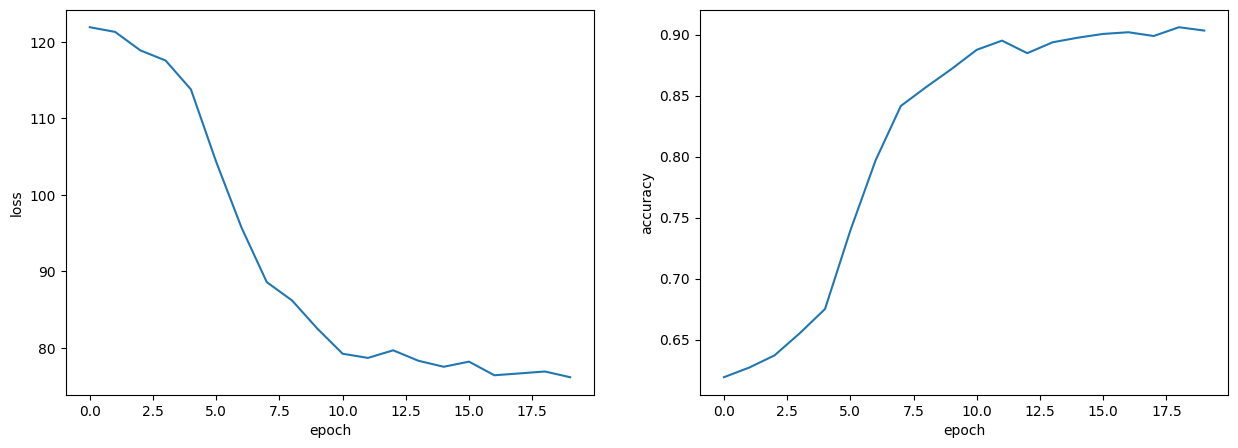

In [30]:
plotTrainRes(results,20)

In [31]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(train_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

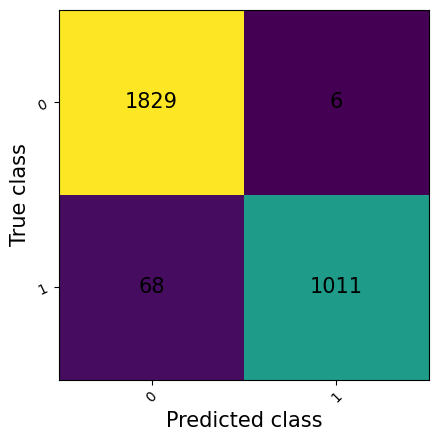

In [32]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

In [33]:
train_model.evaluate(val_dl, True)

Test Batch:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Test Batch: 100%|██████████| 46/46 [04:08<00:00,  5.41s/it]

Val results: Loss - 32.799946546554565, Accuracy - 0.5541838134430727


(32.799946546554565, 0.5541838134430727)

In [34]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(val_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

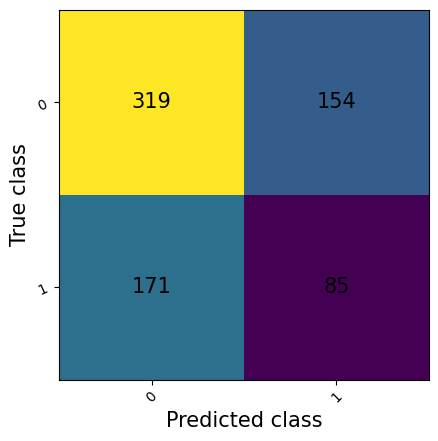

In [35]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

### Full Training with Focal Loss

In [ ]:
config = {'lr':5e-5, 'weight_decay':2e-5, 'step_size': 5, 'gamma': 0.2, 'dropout': 0.5, 'gamma_fl': 2, 'weight': torch.Tensor([1.0,1.0]).to(device)}
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout1d(p=config['dropout']),
    nn.Linear(1280,2),
    nn.Softmax(dim=1)
)

model.to(device)
criterion = BinaryFocalLossWithLogits(alpha=1.0, gamma=config['gamma_fl'], reduction='mean', weight=config['weight'])
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])
train_model = trainer(model,criterion,optimizer,scheduler,device)

In [13]:
train_model = trainer(model,criterion,optimizer,scheduler,device)
results = train_model.train(train_dl,20,True)

Train Batch: 100%|██████████| 183/183 [12:51<00:00,  4.21s/it]


Epoch #0: Loss - 6.1328465305268764, Accuracy - 0.4914207275223061


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.07it/s]


Epoch #1: Loss - 6.054843857884407, Accuracy - 0.5


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #2: Loss - 5.915117243304849, Accuracy - 0.5253946465339739


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #3: Loss - 5.832336265593767, Accuracy - 0.5291695264241593


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #4: Loss - 5.662504868581891, Accuracy - 0.6307481125600549


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #5: Loss - 5.326561817899346, Accuracy - 0.7391901166781057


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #6: Loss - 5.175166809931397, Accuracy - 0.7532601235415237


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #7: Loss - 5.061004040762782, Accuracy - 0.7518874399450927


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #8: Loss - 4.936522556468844, Accuracy - 0.7604667124227865


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #9: Loss - 4.725492935627699, Accuracy - 0.7769389155799589


Train Batch: 100%|██████████| 183/183 [02:51<00:00,  1.06it/s]


Epoch #10: Loss - 4.709816670045257, Accuracy - 0.787920384351407


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #11: Loss - 4.627027185633779, Accuracy - 0.7865477007549759


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #12: Loss - 4.635749513283372, Accuracy - 0.7899794097460535


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #13: Loss - 4.548825519159436, Accuracy - 0.8009608785175018


Train Batch: 100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


Epoch #14: Loss - 4.601880233734846, Accuracy - 0.7810569663692519


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #15: Loss - 4.604658171534538, Accuracy - 0.7954701441317776


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #16: Loss - 4.548015294596553, Accuracy - 0.7927247769389156


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #17: Loss - 4.487369293347001, Accuracy - 0.7978723404255319


Train Batch: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


Epoch #18: Loss - 4.570246739313006, Accuracy - 0.8054221002059025


Train Batch: 100%|██████████| 183/183 [02:55<00:00,  1.05it/s]

Epoch #19: Loss - 4.591530377045274, Accuracy - 0.7958133150308854


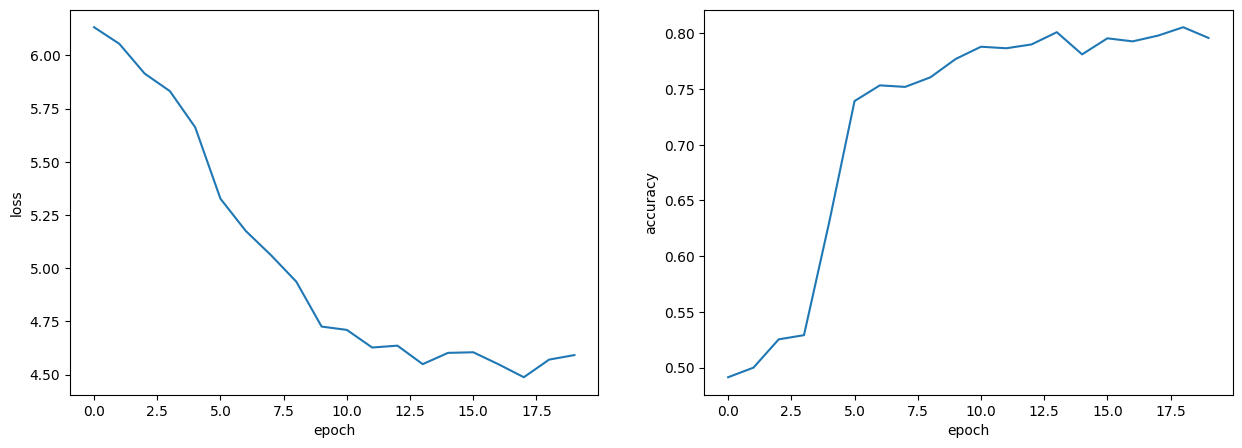

In [14]:
plotTrainRes(results,20)

In [15]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(train_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

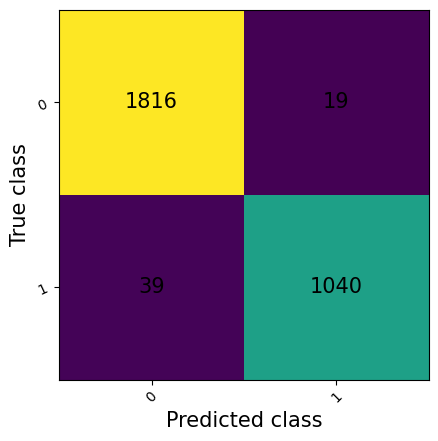

In [16]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

In [17]:
train_model.evaluate(val_dl, True)

Test Batch:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Test Batch: 100%|██████████| 46/46 [02:55<00:00,  3.81s/it]

Val results: Loss - 1.5838827639818192, Accuracy - 0.5582990397805213


(1.5838827639818192, 0.5582990397805213)

In [18]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(val_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

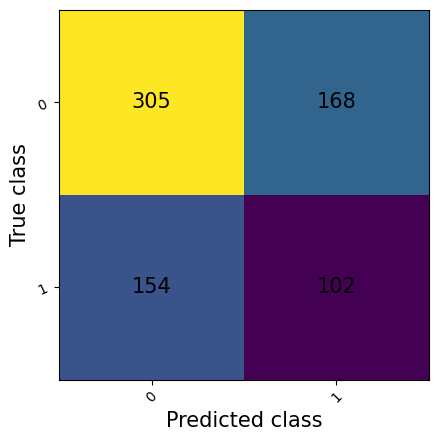

In [19]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()